<a href="https://colab.research.google.com/github/Saoudyahya/salesForcasting/blob/main/salesForcasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as py
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

In [ ]:
store_sales = pd.read_csv('train.csv')
store_sales.head(25)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
store_sales =store_sales.drop(['store','item'],axis=1)

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [ ]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [ ]:
store_sales['date']=store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [ ]:
store_sales['date']=store_sales['date'].dt.to_timestamp()

In [ ]:
store_sales.head(10)

,date,sales
0,2013-01-01,13
1,2013-01-01,11
2,2013-01-01,14
3,2013-01-01,13
4,2013-01-01,10
5,2013-01-01,12
6,2013-01-01,10
7,2013-01-01,9
8,2013-01-01,12
9,2013-01-01,9


In [ ]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02,459417,4513.0
2,2013-03,617382,157965.0
3,2013-04,682274,64892.0
4,2013-05,763242,80968.0
5,2013-06,795597,32355.0
6,2013-07,855922,60325.0
7,2013-08,766761,-89161.0
8,2013-09,689907,-76854.0
9,2013-10,656587,-33320.0
10,2013-11,692643,36056.0


In [ ]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

In [ ]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]

In [ ]:
print(train_data.shape)
print(test_data.shape)

(35, 13)
(12, 13)


In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data )


In [ ]:
x_train,y_train = train_data[:, 1:], train_data[:, 0:1]
x_test,y_test = test_data[:, 1:], test_data[:, 0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (35, 12)
y_train shape (35,)
x_test shape (12, 12)
y_test shape (12,)


In [ ]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)

In [ ]:
import numpy as np

In [ ]:
lr_pred= lr_pred.reshape(-1,1)
lr_pre_test_set=np.concatenate((lr_pred,x_test),axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [ ]:
result_list = []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list,name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series,left_index = True , right_index = True)

In [ ]:
lr_mse= np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print(lr_mse)
print(lr_mae)
print(lr_r2)

16221.272385416869
12433.184266490736
0.9906152516380969


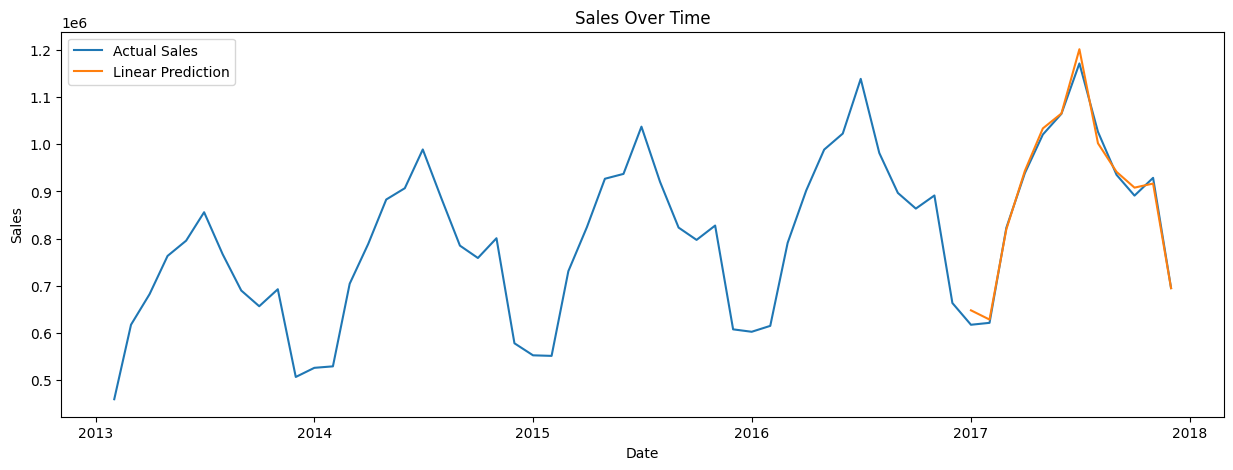

In [ ]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Assuming predict_df['date'] might also need conversion
predict_df['date'] = predict_df['date'].dt.to_timestamp()

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

<ipython-input-37-a8c341744388>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()


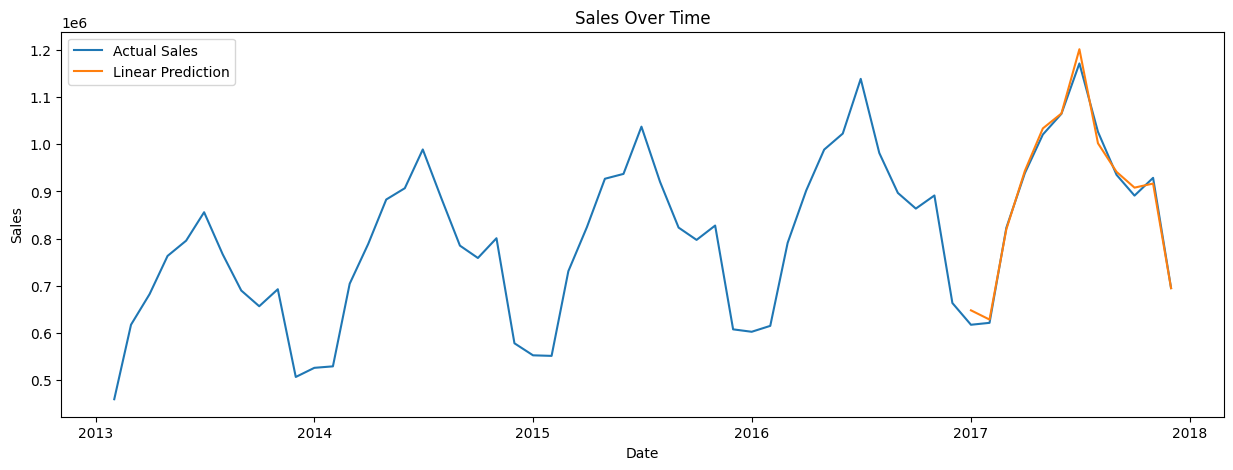

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

store_sales = pd.read_csv('train.csv')
store_sales =store_sales.drop(['store','item'],axis=1)
store_sales['date']=pd.to_datetime(store_sales['date'])
store_sales['date']=store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()
store_sales['date']=store_sales['date'].dt.to_timestamp()
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
supervised_data=monthly_sales.drop(['date','sales'],axis=1)
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)
x_train,y_train = train_data[:, 1:], train_data[:, 0:1]
x_test,y_test = test_data[:, 1:], test_data[:, 0:1]
y_train=y_train.ravel()
y_test=y_test.ravel()
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['sales'][-13:].to_list()
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)
lr_pred= lr_pred.reshape(-1,1)
lr_pre_test_set=np.concatenate((lr_pred,x_test),axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)
result_list = []
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list,name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series,left_index = True , right_index = True)
lr_mse= np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Assuming predict_df['date'] might also need conversion
predict_df['date'] = predict_df['date'].dt.to_timestamp()

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

MSE: 16221.272385416869, MAE: 12433.184266490736, R2: 0.9906152516380969


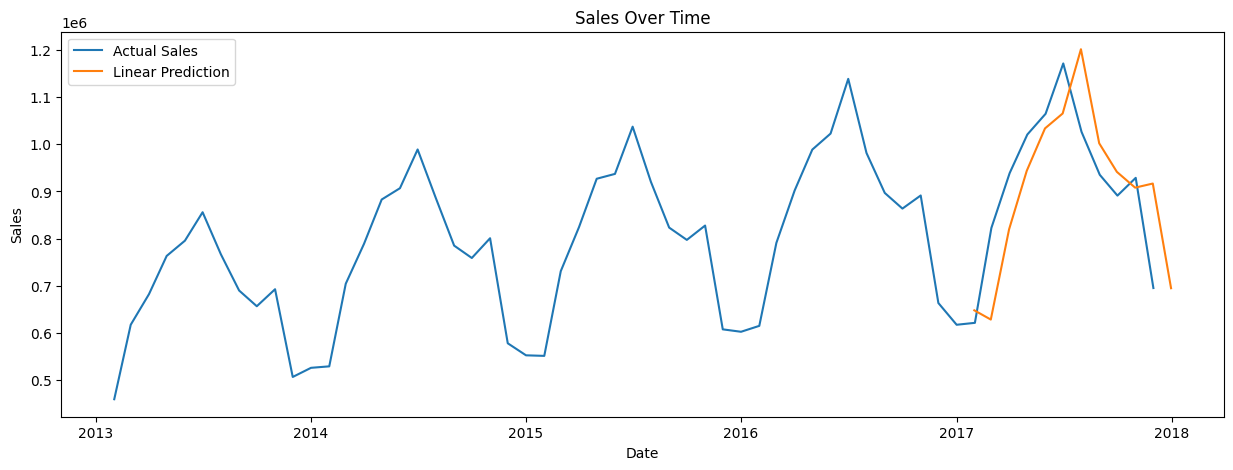

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Custom Transformer to preprocess data
class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler(feature_range=(-1, 1))

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['date'] = pd.to_datetime(X['date'])
        X['date'] = X['date'].dt.to_period('M')
        monthly_sales = X.groupby('date').sum().reset_index()
        X['date'] = X['date'].dt.to_timestamp()
        monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
        monthly_sales = monthly_sales.dropna()
        supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
        for i in range(1, 13):
            col_name = 'month_' + str(i)
            supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
        supervised_data = supervised_data.dropna().reset_index(drop=True)
        train_data = supervised_data[:-12]
        test_data = supervised_data[-12:]
        self.scaler = self.scaler.fit(train_data)
        train_data = self.scaler.transform(train_data)
        test_data = self.scaler.transform(test_data)
        x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
        x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
        y_train = y_train.ravel()
        y_test = y_test.ravel()
        sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
        act_sales = monthly_sales['sales'][-13:].to_list()
        return x_train, y_train, x_test, y_test, sales_dates, act_sales

class ModelPredictor(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        x_train, y_train, _, _, _, _ = X
        self.model.fit(x_train, y_train)
        return self

    def transform(self, X, y=None):
        _, _, x_test, y_test, sales_dates, act_sales = X
        pred = self.model.predict(x_test)
        pred = pred.reshape(-1, 1)
        pred_test_set = np.concatenate((pred, x_test), axis=1)
        pred_test_set = preprocessor.scaler.inverse_transform(pred_test_set)
        result_list = []
        for index in range(0, len(pred_test_set)):
            result_list.append(pred_test_set[index][0] + act_sales[index])
        return result_list, sales_dates, act_sales

class PerformanceMetrics(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        result_list, sales_dates, act_sales = X
        predict_df = pd.DataFrame(sales_dates, columns=['date'])
        predict_df['Linear Prediction'] = result_list
        actual_sales = monthly_sales['sales'][-12:].reset_index(drop=True)
        predict_df = predict_df.merge(actual_sales, left_index=True, right_index=True)
        mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], predict_df['sales']))
        mae = mean_absolute_error(predict_df['Linear Prediction'], predict_df['sales'])
        r2 = r2_score(predict_df['Linear Prediction'], predict_df['sales'])
        print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")
        return predict_df

store_sales = pd.read_csv('train.csv')
store_sales = store_sales.drop(['store', 'item'], axis=1)

preprocessor = DataPreprocessor()
model = ModelPredictor(LinearRegression())
metrics = PerformanceMetrics()

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model),
    ('metrics', metrics)
])

# Fit the pipeline
pipeline.fit(store_sales)

# Get predictions and plot
predict_df = pipeline.transform(store_sales)

plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


Linear Regression - MSE: 16221.272385416869, MAE: 12433.184266490736, R2: 0.9906152516380969
Actual Sales vs. Predicted Sales:
         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


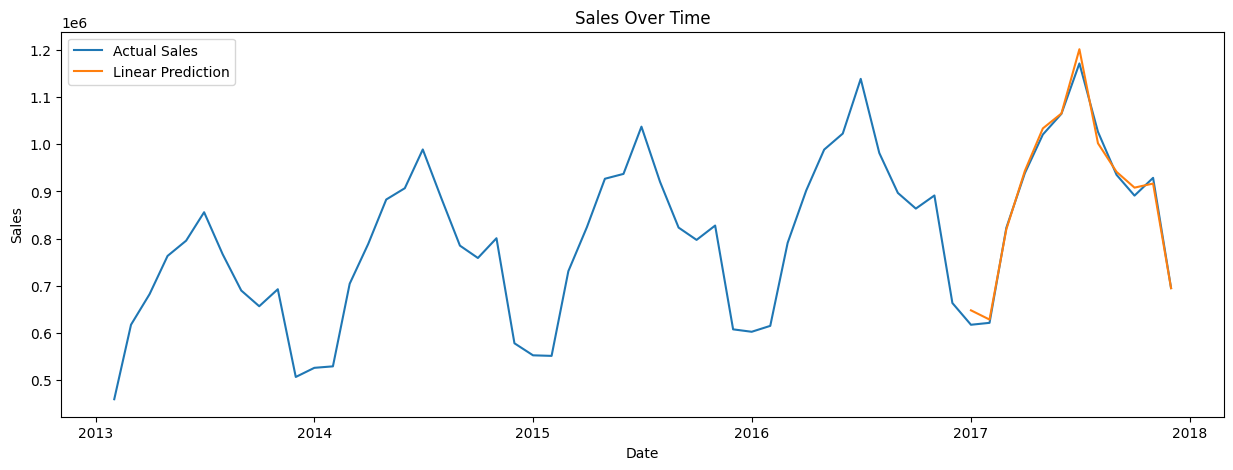

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def load_and_preprocess_data(filepath):
    store_sales = pd.read_csv(filepath)
    store_sales = store_sales.drop(['store', 'item'], axis=1)
    store_sales['date'] = pd.to_datetime(store_sales['date'])
    store_sales['date'] = store_sales['date'].dt.to_period('M')
    monthly_sales = store_sales.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()
    return monthly_sales

def create_supervised_data(monthly_sales, lag=12):
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, lag+1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)
    return supervised_data

def split_and_scale_data(supervised_data, scaler=MinMaxScaler(feature_range=(-1, 1))):
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]
    scaler = scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    x_train, y_train = train_data[:, 1:], train_data[:, 0:1].ravel()
    x_test, y_test = test_data[:, 1:], test_data[:, 0:1].ravel()
    return x_train, y_train, x_test, y_test, scaler

def train_linear_regression(x_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    return lr_model

def inverse_transform_predictions(pred, x_test, scaler, act_sales):
    pred = pred.reshape(-1, 1)
    pred_test_set = np.concatenate((pred, x_test), axis=1)
    pred_test_set = scaler.inverse_transform(pred_test_set)
    result_list = [pred_test_set[index][0] + act_sales[index] for index in range(len(pred_test_set))]
    return result_list

def evaluate_model(predictions, actuals):
    mse = np.sqrt(mean_squared_error(predictions, actuals))
    mae = mean_absolute_error(predictions, actuals)
    r2 = r2_score(predictions, actuals)
    return mse, mae, r2

def plot_predictions(monthly_sales, predict_df, title="Sales Over Time"):
    plt.figure(figsize=(15, 5))
    plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
    plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

def main(filepath):
    monthly_sales = load_and_preprocess_data(filepath)
    supervised_data = create_supervised_data(monthly_sales)
    x_train, y_train, x_test, y_test, scaler = split_and_scale_data(supervised_data)

    lr_model = train_linear_regression(x_train, y_train)
    lr_pred = lr_model.predict(x_test)

    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates)

    act_sales = monthly_sales['sales'][-13:].to_list()
    lr_predictions = inverse_transform_predictions(lr_pred, x_test, scaler, act_sales)
    predict_df['Linear Prediction'] = pd.Series(lr_predictions)

    mse, mae, r2 = evaluate_model(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
    print(f"Linear Regression - MSE: {mse}, MAE: {mae}, R2: {r2}")
    print("Actual Sales vs. Predicted Sales:")
    print(predict_df)
    plot_predictions(monthly_sales, predict_df)

if __name__ == "__main__":
    main('train.csv')


Metrics: {'mse': 0.00633301020621994, 'mae': 0.06099616733341712, 'r2': 0.9806758070651099}


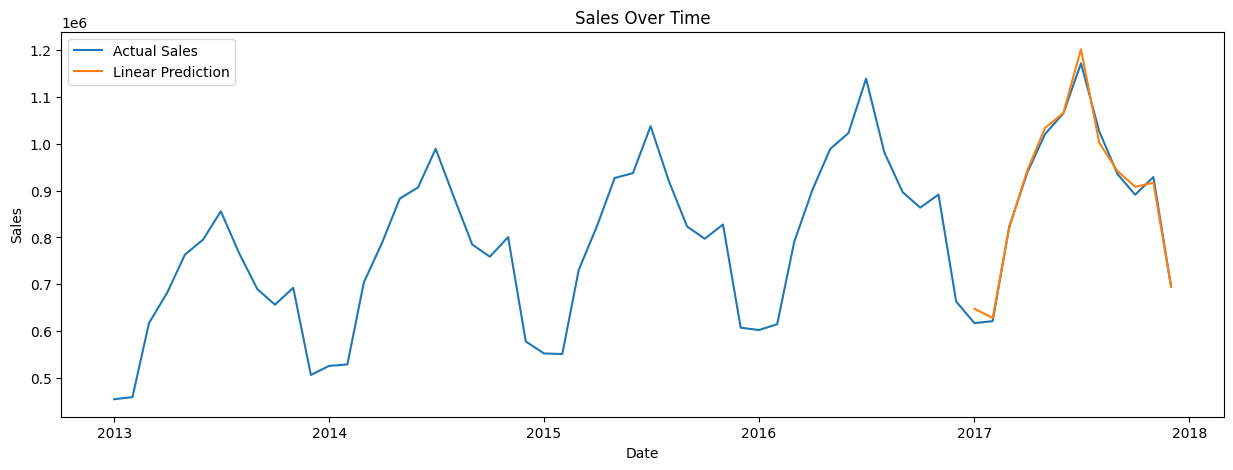

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer to create supervised data
class SupervisedDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lags=12):
        self.lags = lags

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sales_diff = X['sales'].diff().dropna()
        supervised_data = sales_diff.to_frame(name='sales_diff')

        for i in range(1, self.lags + 1):
            col_name = f'month_{i}'
            supervised_data[col_name] = supervised_data['sales_diff'].shift(i)

        supervised_data = supervised_data.dropna().reset_index(drop=True)
        return supervised_data

# Function to split data into train and test sets
def split_data(data, test_size=12):
    return data[:-test_size], data[-test_size:]

# Load and preprocess data
store_sales = pd.read_csv('train.csv')
store_sales = store_sales.drop(['store', 'item'], axis=1)
store_sales['date'] = pd.to_datetime(store_sales['date'])
store_sales['date'] = store_sales['date'].dt.to_period('M')

monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Create supervised data and split into train and test sets
supervised_transformer = SupervisedDataTransformer(lags=12)
supervised_data = supervised_transformer.transform(monthly_sales)

train_data, test_data = split_data(supervised_data, test_size=12)

# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

x_train, y_train = train_data[:, 1:], train_data[:, 0:1]
x_test, y_test = test_data[:, 1:], test_data[:, 0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()

sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)
act_sales = monthly_sales['sales'][-13:].to_list()

# Custom transformer for predictions
class PredictionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        self.model.fit(X, y)
        return self

    def transform(self, X):
        return self.model.predict(X).reshape(-1, 1)

# Custom transformer for metrics
class MetricsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y_true, metric_functions):
        self.y_true = y_true
        self.metric_functions = metric_functions

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        results = {}
        for name, func in self.metric_functions.items():
            results[name] = func(self.y_true, X)
        return results

# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('model', PredictionTransformer(LinearRegression())),
    ('metrics', MetricsTransformer(
        y_true=y_test,
        metric_functions={
            'mse': mean_squared_error,
            'mae': mean_absolute_error,
            'r2': r2_score
        }
    ))
])

# Fit the pipeline and transform the data
pipeline.fit(x_train, y_train)
predictions = pipeline.named_steps['model'].transform(x_test)
metrics = pipeline.named_steps['metrics'].transform(predictions)

# Display metrics
print("Metrics:", metrics)

# Inverse transform the results for prediction visualization
lr_pre_test_set = np.concatenate((predictions, x_test), axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

result_list = []
for index in range(len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
plt.title("Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [ ]:
pip install LangChain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from langchain import LangChain

def preprocess_text_with_langchain(text_data):
    langchain_model = LangChain()
    processed_text = langchain_model.preprocess(text_data)
    return processed_text

def load_and_preprocess_data(filepath):
    store_sales = pd.read_csv(filepath)
    store_sales = store_sales.drop(['store', 'item'], axis=1)
    store_sales['date'] = pd.to_datetime(store_sales['date'])
    store_sales['date'] = store_sales['date'].dt.to_period('M')
    monthly_sales = store_sales.groupby('date').sum().reset_index()
    monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
    monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
    monthly_sales = monthly_sales.dropna()

    if 'text_feature' in store_sales.columns:
        store_sales['text_feature_processed'] = preprocess_text_with_langchain(store_sales['text_feature'])

    return monthly_sales

def create_supervised_data(monthly_sales, lag=12):
    supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, lag+1):
        col_name = 'month_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)
    return supervised_data

def split_and_scale_data(supervised_data, scaler=MinMaxScaler(feature_range=(-1, 1))):
    train_data = supervised_data[:-12]
    test_data = supervised_data[-12:]
    scaler = scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)
    x_train, y_train = train_data[:, 1:], train_data[:, 0:1].ravel()
    x_test, y_test = test_data[:, 1:], test_data[:, 0:1].ravel()
    return x_train, y_train, x_test, y_test, scaler

def train_linear_regression(x_train, y_train):
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    return lr_model

def inverse_transform_predictions(pred, x_test, scaler, act_sales):
    pred = pred.reshape(-1, 1)
    pred_test_set = np.concatenate((pred, x_test), axis=1)
    pred_test_set = scaler.inverse_transform(pred_test_set)
    result_list = [pred_test_set[index][0] + act_sales[index] for index in range(len(pred_test_set))]
    return result_list

def evaluate_model(predictions, actuals):
    mse = np.sqrt(mean_squared_error(predictions, actuals))
    mae = mean_absolute_error(predictions, actuals)
    r2 = r2_score(predictions, actuals)
    return mse, mae, r2

def plot_predictions(monthly_sales, predict_df, title="Sales Over Time"):
    plt.figure(figsize=(15, 5))
    plt.plot(monthly_sales['date'], monthly_sales['sales'], label='Actual Sales')
    plt.plot(predict_df['date'], predict_df['Linear Prediction'], label='Linear Prediction')
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.show()

def generate_prediction_summary(predict_df, monthly_sales):
    prediction_summary = "Based on our linear regression model, we predict sales for the next 12 months as follows:\n"
    for i, row in predict_df.iterrows():
        date = row['date'].strftime('%B %Y')
        prediction = row['Linear Prediction']
        actual = monthly_sales['sales'].iloc[-12 + i]
        prediction_summary += f"In {date}, we predict sales to be ${prediction:.2f}, compared to actual sales of ${actual:.2f}.\n"
    return prediction_summary

def main(filepath):
    monthly_sales = load_and_preprocess_data(filepath)
    supervised_data = create_supervised_data(monthly_sales)
    x_train, y_train, x_test, y_test, scaler = split_and_scale_data(supervised_data)

    lr_model = train_linear_regression(x_train, y_train)
    lr_pred = lr_model.predict(x_test)

    sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates)

    act_sales = monthly_sales['sales'][-13:].to_list()
    lr_predictions = inverse_transform_predictions(lr_pred, x_test, scaler, act_sales)
    predict_df['Linear Prediction'] = pd.Series(lr_predictions)

    mse, mae, r2 = evaluate_model(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
    print(f"Linear Regression - MSE: {mse}, MAE: {mae}, R2: {r2}")

    plot_predictions(monthly_sales, predict_df)

    prediction_summary = generate_prediction_summary(predict_df, monthly_sales)
    print("\nPrediction Summary:")
    print(prediction_summary)

if __name__ == "__main__":
    main('train.csv')


ImportError: cannot import name 'LangChain' from 'langchain' (/usr/local/lib/python3.10/dist-packages/langchain/__init__.py)